In [1]:
from astropy.table import Table, Column, Row, MaskedColumn
import random
import time
from datetime import date
import calendar
import numpy as np
import matplotlib.pyplot as plt

First I read in my weather stats table - it probably is too basic a model but it is adequate for now, and for now I can get a feel for scatter based on runnign the "dry" and "wet" tables


In [2]:
wdata = Table.read('data/weather-average.csv', format='csv')

# wdata = Table.read('data/weather-average-dry.csv', format='csv')
# wdata = Table.read('weather-average-wet.csv', format='csv')

I then make new columns containing the cumulative fraction of time in each weather band (for use later). 

In [3]:
CumulativeBand1 = Column(wdata['Band1Percentage'], name='CumulativeBand1', format='.1f')
wdata.add_column(CumulativeBand1)
CumulativeBand2 = Column([x['CumulativeBand1']+x['Band2Percentage'] for x in wdata], name='CumulativeBand2', format='.1f')
wdata.add_column(CumulativeBand2)
CumulativeBand3 = Column([x['CumulativeBand2']+x['Band3Percentage'] for x in wdata], name='CumulativeBand3', format='.1f')
wdata.add_column(CumulativeBand3)
CumulativeBand4 = Column([x['CumulativeBand3']+x['Band4Percentage'] for x in wdata], name='CumulativeBand4', format='.1f')
wdata.add_column(CumulativeBand4)
CumulativeBand5 = Column([x['CumulativeBand4']+x['Band5Percentage'] for x in wdata], name='CumulativeBand5', format='.1f')
wdata.add_column(CumulativeBand5)

In [4]:
#wdata

I define a loook up dictionary for easy table access - months are not month values but rather positions in the table


In [5]:
dict = {'February': 0, 'March': 1, 'April': 2, 'May': 3, 'June': 4, 'July': 5, 'August': 6, 'September': 7, 'October': 8, 'November': 9, 'December': 10, 'January': 11}

Now I need to load in my schedule file from this it will detemrine the month and number of days I need to predict for. From this I need to be able to 

i) know month and number of days - to allocated a weather band for the night

ii) UT date and weather bad is then needed as input into Michael Polhen's code

In [8]:
sdata = Table.read('data/18A_schedule.csv', format='csv')

yearForTable = Column([int(x/10000) for x in sdata['Date']], name='Year')
monthForTable = Column([calendar.month_name[ int(int(x-((int(x/10000))*10000))/100)] for x in sdata['Date']], name='Month')
dayForTable = Column([x - (int(x/100)*100) for x in sdata['Date']], name='Day')

sdata.add_column(yearForTable)
sdata.add_column(monthForTable)
sdata.add_column(dayForTable)

#sdata

In [10]:
# obtaines data when not PI time (PI in this example = UH and DDT and E&C)

PIdata =  sdata[sdata['Priority1']=='PI'] 

LAPsdata = sdata[sdata['Priority1']!='PI'] 

#print (LAPsdata)

In [15]:
# NEW Method::::
# trying to get 'February','March' automatically

monthgroupstable = sdata.group_by('Month') # group_by method.
monthstoexamine = len(monthgroupstable.groups.keys)
print (monthgroupstable.groups.keys) #alphabetically ordered! huh - not ideal

for x in range(0,monthstoexamine,1):
    print (x)
    print (monthgroupstable.groups.keys[x])

 Month  
--------
   April
February
    July
    June
   March
     May
0
Month
-----
April
1
 Month  
--------
February
2
Month
-----
 July
3
Month
-----
 June
4
Month
-----
March
5
Month
-----
  May


In [18]:
# old Method:::::
# for now only look at one month

monthlist = ('February','March','April','May','June','July') # I want to generate this automatically 
for x in monthlist:
    month = x#'February'#'February'
    MonthLAPSdata = LAPsdata[LAPsdata['Month']==month] #### here is when we seperate by month....
    numberofdays = (len(MonthLAPSdata))
    print (x,numberofdays)
    print(MonthLAPSdata)


February 14
  Date   Priority1 Priority2 Year  Month   Day
-------- --------- --------- ---- -------- ---
20180201  M16AL006  M17BL009 2018 February   1
20180202  M16AL006  M17BL009 2018 February   2
20180203  M16AL006  M17BL009 2018 February   3
20180204  M16AL006  M17BL009 2018 February   4
20180205  M16AL006  M17BL009 2018 February   5
20180206  M17BL004        -- 2018 February   6
20180207  M17BL004        -- 2018 February   7
20180208  M17BL004        -- 2018 February   8
20180209  M17BL004        -- 2018 February   9
20180210  M17BL004        -- 2018 February  10
20180216  M16AL004  M17BL011 2018 February  16
20180217  M16AL004  M17BL011 2018 February  17
20180218  M16AL004  M17BL011 2018 February  18
20180219  M16AL004  M17BL011 2018 February  19
March 19
  Date   Priority1 Priority2 Year Month Day
-------- --------- --------- ---- ----- ---
20180302  M16AL006  M17BL009 2018 March   2
20180303  M16AL006  M17BL009 2018 March   3
20180304  M16AL006  M17BL009 2018 March   4
2018030

In [19]:
print ("Examining {} nights alloacted in {} \n".format(numberofdays,month))
print (("fraction of nights Band 1={}%, 2={}%, 3={}%, 4={}% and 5={}%\n".format(wdata['Band1Percentage'][dict[month]],wdata['Band2Percentage'][dict[month]],wdata['Band3Percentage'][dict[month]],wdata['Band4Percentage'][dict[month]],wdata['Band5Percentage'][dict[month]])))


Examining 13 nights alloacted in July 

fraction of nights Band 1=3.2%, 2=27.6%, 3=32.3%, 4=22.2% and 5=9.2%



In [20]:
# keeping it simple - allocating an entire night to one weather band
# but doing a crappy job - issue is with small number of nights

b1nights = round(numberofdays*wdata['Band1Percentage'][dict[month]]/100,)
b2nights = round(numberofdays*wdata['Band2Percentage'][dict[month]]/100)
b3nights = round(numberofdays*wdata['Band3Percentage'][dict[month]]/100)
b4nights = round(numberofdays*wdata['Band4Percentage'][dict[month]]/100)
b5nights = round(numberofdays*wdata['Band5Percentage'][dict[month]]/100)
b6nights = round(numberofdays*(100-wdata['CumulativeBand5'][dict[month]])/100)

#print((numberofdays*(100-wdata['CumulativeBand5'][dict[month]])/100))

#print (b1nights,b2nights,b3nights,b4nights,b5nights,b6nights)

sdatabanddata  = []

for i in range(numberofdays):
#     print(i)
    if 0 <= i < b1nights:
#         print ("band 1")
        sdatabanddata.append(1)
    if b1nights <= i < (b1nights+b2nights):
#         print ("band 2")
        sdatabanddata.append(2)
    if (b1nights+b2nights) <= i < (b1nights+b2nights+b3nights):
#         print ("band 3")
        sdatabanddata.append(3)
    if (b1nights+b2nights+b3nights) <= i < (b1nights+b2nights+b3nights+b4nights):
#         print ("band 4")
        sdatabanddata.append(4)
    if (b1nights+b2nights+b3nights+b4nights) <= i < (b1nights+b2nights+b3nights+b4nights+b5nights):
#         print ("band 5")
        sdatabanddata.append(5)
    if (b1nights+b2nights+b3nights+b4nights+b5nights) <= i:
#         print ("closed")
        sdatabanddata.append(6)

print (sdatabanddata,type(sdatabanddata))
rsdatabanddata = random.sample(sdatabanddata, len(sdatabanddata)) 
print (rsdatabanddata,type(rsdatabanddata))

[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 6] <class 'list'>
[3, 3, 2, 2, 3, 5, 6, 2, 4, 4, 2, 3, 4] <class 'list'>


In [21]:
modelband1frac = sdatabanddata.count(1)/len(sdatabanddata)
modelband2frac = sdatabanddata.count(2)/len(sdatabanddata)
modelband3frac = sdatabanddata.count(3)/len(sdatabanddata)
modelband4frac = sdatabanddata.count(4)/len(sdatabanddata)
modelband5frac = sdatabanddata.count(5)/len(sdatabanddata)
modelband6frac = sdatabanddata.count(6)/len(sdatabanddata)

Now I want to add in these weather bands to my table for each night

In [22]:
weatherForTable = Column([rsdatabanddata[x] for x in range(numberofdays)], name='Weather')
MonthLAPSdata.add_column(weatherForTable) # error if run multiple time

In [23]:
MonthLAPSdata

Date,Priority1,Priority2,Year,Month,Day,Weather
int64,str8,str8,int64,str8,int64,int64
20180706,M17BL005,--,2018,July,6,3
20180707,M17BL005,--,2018,July,7,3
20180708,M17BL005,--,2018,July,8,2
20180709,M17BL005,--,2018,July,9,2
20180710,M17BL005,--,2018,July,10,3
20180716,M17BL004,--,2018,July,16,5
20180717,M17BL004,--,2018,July,17,6
20180718,M17BL004,--,2018,July,18,2
20180719,M17BL004,--,2018,July,19,4


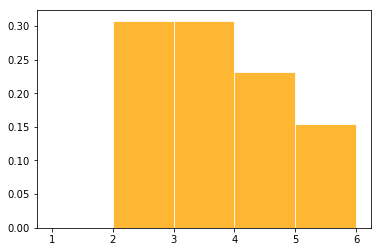

fraction of nights Band 1=3.2%, 2=27.6%, 3=32.3%, 4=22.2% and 5=9.2%

fraction of nights Band 1=0.0%, 2=30.8%, 3=30.8%, 4=23.1% and 5=7.7%



In [27]:
#Plot histogram of days:
plt.figure()
plt.hist(MonthLAPSdata['Weather'], bins=[1,2,3,4,5,6], label='default', edgecolor='white', facecolor='orange', alpha=0.8, normed=1)
plt.show()
print (("fraction of nights Band 1={}%, 2={}%, 3={}%, 4={}% and 5={}%\n".format(wdata['Band1Percentage'][dict[month]],wdata['Band2Percentage'][dict[month]],wdata['Band3Percentage'][dict[month]],wdata['Band4Percentage'][dict[month]],wdata['Band5Percentage'][dict[month]])))
print (("fraction of nights Band 1={:.1f}%, 2={:.1f}%, 3={:.1f}%, 4={:.1f}% and 5={:.1f}%\n".format(modelband1frac*100,modelband2frac*100,modelband3frac*100,modelband4frac*100,modelband5frac*100)))


In essence I then need to calculate how many night in a month are in each weatherbands and run Michael's code on the relevent 